# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Instructions for updating:
Please write your own downloading logic.


Instructions for updating:
Please use urllib or similar directly.


Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.


Extracting MNIST_data/train-images-idx3-ubyte.gz


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.


Extracting MNIST_data/train-labels-idx1-ubyte.gz


Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz


Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


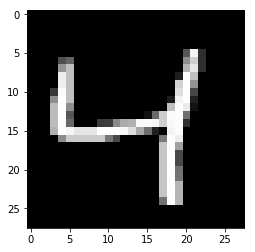

In [4]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [7]:
mnist.train.images.shape

(60000, 784)

In [9]:
learning_rate = 0.001
# Input and target placeholders
#tf.placeholder(dtype, shape=None, name=None)
inputs_ = tf.placeholder(tf.float32, shape=(None,28,28,1), name='inputs')
targets_ = tf.placeholder(tf.float32, shape=(None,28,28,1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool2, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded,(7,7))
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(conv6,1,(3,3),padding='same',activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [11]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6960


Epoch: 1/20... Training loss: 0.6923


Epoch: 1/20... Training loss: 0.6894


Epoch: 1/20... Training loss: 0.6865


Epoch: 1/20... Training loss: 0.6829


Epoch: 1/20... Training loss: 0.6789


Epoch: 1/20... Training loss: 0.6734


Epoch: 1/20... Training loss: 0.6668


Epoch: 1/20... Training loss: 0.6583


Epoch: 1/20... Training loss: 0.6482


Epoch: 1/20... Training loss: 0.6372


Epoch: 1/20... Training loss: 0.6212


Epoch: 1/20... Training loss: 0.6064


Epoch: 1/20... Training loss: 0.5903


Epoch: 1/20... Training loss: 0.5718


Epoch: 1/20... Training loss: 0.5539


Epoch: 1/20... Training loss: 0.5364


Epoch: 1/20... Training loss: 0.5310


Epoch: 1/20... Training loss: 0.5288


Epoch: 1/20... Training loss: 0.5563


Epoch: 1/20... Training loss: 0.5467


Epoch: 1/20... Training loss: 0.5719


Epoch: 1/20... Training loss: 0.5332


Epoch: 1/20... Training loss: 0.5221


Epoch: 1/20... Training loss: 0.5082


Epoch: 1/20... Training loss: 0.5106


Epoch: 1/20... Training loss: 0.5015


Epoch: 1/20... Training loss: 0.5024


Epoch: 1/20... Training loss: 0.5003


Epoch: 1/20... Training loss: 0.5010


Epoch: 1/20... Training loss: 0.4902


Epoch: 1/20... Training loss: 0.4918


Epoch: 1/20... Training loss: 0.4798


Epoch: 1/20... Training loss: 0.4708


Epoch: 1/20... Training loss: 0.4666


Epoch: 1/20... Training loss: 0.4632


Epoch: 1/20... Training loss: 0.4596


Epoch: 1/20... Training loss: 0.4509


Epoch: 1/20... Training loss: 0.4461


Epoch: 1/20... Training loss: 0.4371


Epoch: 1/20... Training loss: 0.4418


Epoch: 1/20... Training loss: 0.4280


Epoch: 1/20... Training loss: 0.4114


Epoch: 1/20... Training loss: 0.4029


Epoch: 1/20... Training loss: 0.4017


Epoch: 1/20... Training loss: 0.3876


Epoch: 1/20... Training loss: 0.3758


Epoch: 1/20... Training loss: 0.3673


Epoch: 1/20... Training loss: 0.3612


Epoch: 1/20... Training loss: 0.3501


Epoch: 1/20... Training loss: 0.3520


Epoch: 1/20... Training loss: 0.3393


Epoch: 1/20... Training loss: 0.3316


Epoch: 1/20... Training loss: 0.3131


Epoch: 1/20... Training loss: 0.3173


Epoch: 1/20... Training loss: 0.3156


Epoch: 1/20... Training loss: 0.2980


Epoch: 1/20... Training loss: 0.2953


Epoch: 1/20... Training loss: 0.2893


Epoch: 1/20... Training loss: 0.2872


Epoch: 1/20... Training loss: 0.2778


Epoch: 1/20... Training loss: 0.2703


Epoch: 1/20... Training loss: 0.2688


Epoch: 1/20... Training loss: 0.2743


Epoch: 1/20... Training loss: 0.2582


Epoch: 1/20... Training loss: 0.2574


Epoch: 1/20... Training loss: 0.2508


Epoch: 1/20... Training loss: 0.2519


Epoch: 1/20... Training loss: 0.2552


Epoch: 1/20... Training loss: 0.2406


Epoch: 1/20... Training loss: 0.2347


Epoch: 1/20... Training loss: 0.2429


Epoch: 1/20... Training loss: 0.2317


Epoch: 1/20... Training loss: 0.2388


Epoch: 1/20... Training loss: 0.2309


Epoch: 1/20... Training loss: 0.2337


Epoch: 1/20... Training loss: 0.2271


Epoch: 1/20... Training loss: 0.2257


Epoch: 1/20... Training loss: 0.2324


Epoch: 1/20... Training loss: 0.2303


Epoch: 1/20... Training loss: 0.2211


Epoch: 1/20... Training loss: 0.2206


Epoch: 1/20... Training loss: 0.2211


Epoch: 1/20... Training loss: 0.2232


Epoch: 1/20... Training loss: 0.2155


Epoch: 1/20... Training loss: 0.2143


Epoch: 1/20... Training loss: 0.2097


Epoch: 1/20... Training loss: 0.2122


Epoch: 1/20... Training loss: 0.2076


Epoch: 1/20... Training loss: 0.2087


Epoch: 1/20... Training loss: 0.2122


Epoch: 1/20... Training loss: 0.2004


Epoch: 1/20... Training loss: 0.2098


Epoch: 1/20... Training loss: 0.2027


Epoch: 1/20... Training loss: 0.2061


Epoch: 1/20... Training loss: 0.2096


Epoch: 1/20... Training loss: 0.2058


Epoch: 1/20... Training loss: 0.2063


Epoch: 1/20... Training loss: 0.1995


Epoch: 1/20... Training loss: 0.2053


Epoch: 1/20... Training loss: 0.2027


Epoch: 1/20... Training loss: 0.1988


Epoch: 1/20... Training loss: 0.2016


Epoch: 1/20... Training loss: 0.2002


Epoch: 1/20... Training loss: 0.1977


Epoch: 1/20... Training loss: 0.1956


Epoch: 1/20... Training loss: 0.1989


Epoch: 1/20... Training loss: 0.1914


Epoch: 1/20... Training loss: 0.1949


Epoch: 1/20... Training loss: 0.1978


Epoch: 1/20... Training loss: 0.1922


Epoch: 1/20... Training loss: 0.1971


Epoch: 1/20... Training loss: 0.1963


Epoch: 1/20... Training loss: 0.1984


Epoch: 1/20... Training loss: 0.1900


Epoch: 1/20... Training loss: 0.1893


Epoch: 1/20... Training loss: 0.1851


Epoch: 1/20... Training loss: 0.1935


Epoch: 1/20... Training loss: 0.1879


Epoch: 1/20... Training loss: 0.1971


Epoch: 1/20... Training loss: 0.1850


Epoch: 1/20... Training loss: 0.1869


Epoch: 1/20... Training loss: 0.1941


Epoch: 1/20... Training loss: 0.1884


Epoch: 1/20... Training loss: 0.1855


Epoch: 1/20... Training loss: 0.1871


Epoch: 1/20... Training loss: 0.1853


Epoch: 1/20... Training loss: 0.1869


Epoch: 1/20... Training loss: 0.1830


Epoch: 1/20... Training loss: 0.1808


Epoch: 1/20... Training loss: 0.1790


Epoch: 1/20... Training loss: 0.1868


Epoch: 1/20... Training loss: 0.1825


Epoch: 1/20... Training loss: 0.1817


Epoch: 1/20... Training loss: 0.1862


Epoch: 1/20... Training loss: 0.1792


Epoch: 1/20... Training loss: 0.1785


Epoch: 1/20... Training loss: 0.1789


Epoch: 1/20... Training loss: 0.1808


Epoch: 1/20... Training loss: 0.1842


Epoch: 1/20... Training loss: 0.1795


Epoch: 1/20... Training loss: 0.1799


Epoch: 1/20... Training loss: 0.1799


Epoch: 1/20... Training loss: 0.1807


Epoch: 1/20... Training loss: 0.1788


Epoch: 1/20... Training loss: 0.1731


Epoch: 1/20... Training loss: 0.1785


Epoch: 1/20... Training loss: 0.1862


Epoch: 1/20... Training loss: 0.1794


Epoch: 1/20... Training loss: 0.1846


Epoch: 1/20... Training loss: 0.1785


Epoch: 1/20... Training loss: 0.1761


Epoch: 1/20... Training loss: 0.1768


Epoch: 1/20... Training loss: 0.1751


Epoch: 1/20... Training loss: 0.1723


Epoch: 1/20... Training loss: 0.1738


Epoch: 1/20... Training loss: 0.1783


Epoch: 1/20... Training loss: 0.1752


Epoch: 1/20... Training loss: 0.1708


Epoch: 1/20... Training loss: 0.1755


Epoch: 1/20... Training loss: 0.1679


Epoch: 1/20... Training loss: 0.1719


Epoch: 1/20... Training loss: 0.1722


Epoch: 1/20... Training loss: 0.1746


Epoch: 1/20... Training loss: 0.1665


Epoch: 1/20... Training loss: 0.1719


Epoch: 1/20... Training loss: 0.1704


Epoch: 1/20... Training loss: 0.1697


Epoch: 1/20... Training loss: 0.1740


Epoch: 1/20... Training loss: 0.1675


Epoch: 1/20... Training loss: 0.1678


Epoch: 1/20... Training loss: 0.1727


Epoch: 1/20... Training loss: 0.1701


Epoch: 1/20... Training loss: 0.1682


Epoch: 1/20... Training loss: 0.1714


Epoch: 1/20... Training loss: 0.1615


Epoch: 1/20... Training loss: 0.1709


Epoch: 1/20... Training loss: 0.1779


Epoch: 1/20... Training loss: 0.1680


Epoch: 1/20... Training loss: 0.1712


Epoch: 1/20... Training loss: 0.1688


Epoch: 1/20... Training loss: 0.1680


Epoch: 1/20... Training loss: 0.1706


Epoch: 1/20... Training loss: 0.1664


Epoch: 1/20... Training loss: 0.1683


Epoch: 1/20... Training loss: 0.1698


Epoch: 1/20... Training loss: 0.1686


Epoch: 1/20... Training loss: 0.1611


Epoch: 1/20... Training loss: 0.1713


Epoch: 1/20... Training loss: 0.1690


Epoch: 1/20... Training loss: 0.1651


Epoch: 1/20... Training loss: 0.1612


Epoch: 1/20... Training loss: 0.1648


Epoch: 1/20... Training loss: 0.1648


Epoch: 1/20... Training loss: 0.1650


Epoch: 1/20... Training loss: 0.1631


Epoch: 1/20... Training loss: 0.1660


Epoch: 1/20... Training loss: 0.1621


Epoch: 1/20... Training loss: 0.1678


Epoch: 1/20... Training loss: 0.1635


Epoch: 1/20... Training loss: 0.1601


Epoch: 1/20... Training loss: 0.1562


Epoch: 1/20... Training loss: 0.1569


Epoch: 1/20... Training loss: 0.1602


Epoch: 1/20... Training loss: 0.1595


Epoch: 1/20... Training loss: 0.1677


Epoch: 1/20... Training loss: 0.1584


Epoch: 1/20... Training loss: 0.1650


Epoch: 1/20... Training loss: 0.1669


Epoch: 1/20... Training loss: 0.1669


Epoch: 1/20... Training loss: 0.1647


Epoch: 1/20... Training loss: 0.1587


Epoch: 1/20... Training loss: 0.1548


Epoch: 1/20... Training loss: 0.1593


Epoch: 1/20... Training loss: 0.1655


Epoch: 1/20... Training loss: 0.1606


Epoch: 1/20... Training loss: 0.1624


Epoch: 1/20... Training loss: 0.1527


Epoch: 1/20... Training loss: 0.1590


Epoch: 1/20... Training loss: 0.1611


Epoch: 1/20... Training loss: 0.1603


Epoch: 1/20... Training loss: 0.1626


Epoch: 1/20... Training loss: 0.1621


Epoch: 1/20... Training loss: 0.1609


Epoch: 1/20... Training loss: 0.1553


Epoch: 1/20... Training loss: 0.1617


Epoch: 1/20... Training loss: 0.1579


Epoch: 1/20... Training loss: 0.1612


Epoch: 1/20... Training loss: 0.1505


Epoch: 1/20... Training loss: 0.1547


Epoch: 1/20... Training loss: 0.1574


Epoch: 1/20... Training loss: 0.1610


Epoch: 1/20... Training loss: 0.1572


Epoch: 1/20... Training loss: 0.1604


Epoch: 1/20... Training loss: 0.1600


Epoch: 1/20... Training loss: 0.1559


Epoch: 1/20... Training loss: 0.1585


Epoch: 1/20... Training loss: 0.1521


Epoch: 1/20... Training loss: 0.1595


Epoch: 1/20... Training loss: 0.1624


Epoch: 1/20... Training loss: 0.1595


Epoch: 1/20... Training loss: 0.1579


Epoch: 1/20... Training loss: 0.1538


Epoch: 1/20... Training loss: 0.1561


Epoch: 1/20... Training loss: 0.1528


Epoch: 1/20... Training loss: 0.1545


Epoch: 1/20... Training loss: 0.1565


Epoch: 1/20... Training loss: 0.1530


Epoch: 1/20... Training loss: 0.1558


Epoch: 1/20... Training loss: 0.1566


Epoch: 1/20... Training loss: 0.1494


Epoch: 1/20... Training loss: 0.1551


Epoch: 1/20... Training loss: 0.1462


Epoch: 1/20... Training loss: 0.1552


Epoch: 1/20... Training loss: 0.1473


Epoch: 1/20... Training loss: 0.1543


Epoch: 1/20... Training loss: 0.1562


Epoch: 1/20... Training loss: 0.1513


Epoch: 1/20... Training loss: 0.1553


Epoch: 1/20... Training loss: 0.1503


Epoch: 1/20... Training loss: 0.1584


Epoch: 1/20... Training loss: 0.1570


Epoch: 1/20... Training loss: 0.1564


Epoch: 1/20... Training loss: 0.1520


Epoch: 1/20... Training loss: 0.1595


Epoch: 1/20... Training loss: 0.1541


Epoch: 1/20... Training loss: 0.1521


Epoch: 1/20... Training loss: 0.1534


Epoch: 1/20... Training loss: 0.1514


Epoch: 1/20... Training loss: 0.1534


Epoch: 1/20... Training loss: 0.1506


Epoch: 1/20... Training loss: 0.1507


Epoch: 1/20... Training loss: 0.1539


Epoch: 1/20... Training loss: 0.1537


Epoch: 1/20... Training loss: 0.1478


Epoch: 1/20... Training loss: 0.1558


Epoch: 1/20... Training loss: 0.1529


Epoch: 1/20... Training loss: 0.1522


Epoch: 1/20... Training loss: 0.1501


Epoch: 1/20... Training loss: 0.1513


Epoch: 1/20... Training loss: 0.1461


Epoch: 1/20... Training loss: 0.1505


Epoch: 1/20... Training loss: 0.1503


Epoch: 1/20... Training loss: 0.1525


Epoch: 1/20... Training loss: 0.1512


Epoch: 1/20... Training loss: 0.1465


Epoch: 1/20... Training loss: 0.1457


Epoch: 1/20... Training loss: 0.1484


Epoch: 1/20... Training loss: 0.1547


Epoch: 1/20... Training loss: 0.1468


Epoch: 1/20... Training loss: 0.1472


Epoch: 1/20... Training loss: 0.1467


Epoch: 1/20... Training loss: 0.1425


Epoch: 1/20... Training loss: 0.1516


Epoch: 1/20... Training loss: 0.1547


Epoch: 1/20... Training loss: 0.1467


Epoch: 1/20... Training loss: 0.1533


Epoch: 1/20... Training loss: 0.1508


Epoch: 1/20... Training loss: 0.1474


Epoch: 1/20... Training loss: 0.1471


Epoch: 2/20... Training loss: 0.1524


Epoch: 2/20... Training loss: 0.1530


Epoch: 2/20... Training loss: 0.1466


Epoch: 2/20... Training loss: 0.1370


Epoch: 2/20... Training loss: 0.1492


Epoch: 2/20... Training loss: 0.1553


Epoch: 2/20... Training loss: 0.1525


Epoch: 2/20... Training loss: 0.1446


Epoch: 2/20... Training loss: 0.1451


Epoch: 2/20... Training loss: 0.1483


Epoch: 2/20... Training loss: 0.1471


Epoch: 2/20... Training loss: 0.1488


Epoch: 2/20... Training loss: 0.1452


Epoch: 2/20... Training loss: 0.1471


Epoch: 2/20... Training loss: 0.1471


Epoch: 2/20... Training loss: 0.1403


Epoch: 2/20... Training loss: 0.1458


Epoch: 2/20... Training loss: 0.1450


Epoch: 2/20... Training loss: 0.1478


Epoch: 2/20... Training loss: 0.1444


Epoch: 2/20... Training loss: 0.1474


Epoch: 2/20... Training loss: 0.1435


Epoch: 2/20... Training loss: 0.1479


Epoch: 2/20... Training loss: 0.1449


Epoch: 2/20... Training loss: 0.1466


Epoch: 2/20... Training loss: 0.1430


Epoch: 2/20... Training loss: 0.1500


Epoch: 2/20... Training loss: 0.1424


Epoch: 2/20... Training loss: 0.1478


Epoch: 2/20... Training loss: 0.1430


Epoch: 2/20... Training loss: 0.1499


Epoch: 2/20... Training loss: 0.1426


Epoch: 2/20... Training loss: 0.1483


Epoch: 2/20... Training loss: 0.1411


Epoch: 2/20... Training loss: 0.1466


Epoch: 2/20... Training loss: 0.1443


Epoch: 2/20... Training loss: 0.1519


Epoch: 2/20... Training loss: 0.1404


Epoch: 2/20... Training loss: 0.1402


Epoch: 2/20... Training loss: 0.1440


Epoch: 2/20... Training loss: 0.1438


Epoch: 2/20... Training loss: 0.1499


Epoch: 2/20... Training loss: 0.1438


Epoch: 2/20... Training loss: 0.1407


Epoch: 2/20... Training loss: 0.1436


Epoch: 2/20... Training loss: 0.1517


Epoch: 2/20... Training loss: 0.1410


Epoch: 2/20... Training loss: 0.1361


Epoch: 2/20... Training loss: 0.1489


Epoch: 2/20... Training loss: 0.1460


Epoch: 2/20... Training loss: 0.1460


Epoch: 2/20... Training loss: 0.1455


Epoch: 2/20... Training loss: 0.1442


Epoch: 2/20... Training loss: 0.1409


Epoch: 2/20... Training loss: 0.1362


Epoch: 2/20... Training loss: 0.1432


Epoch: 2/20... Training loss: 0.1447


Epoch: 2/20... Training loss: 0.1438


Epoch: 2/20... Training loss: 0.1419


Epoch: 2/20... Training loss: 0.1437


Epoch: 2/20... Training loss: 0.1389


Epoch: 2/20... Training loss: 0.1485


Epoch: 2/20... Training loss: 0.1436


Epoch: 2/20... Training loss: 0.1504


Epoch: 2/20... Training loss: 0.1442


Epoch: 2/20... Training loss: 0.1419


Epoch: 2/20... Training loss: 0.1399


Epoch: 2/20... Training loss: 0.1429


Epoch: 2/20... Training loss: 0.1446


Epoch: 2/20... Training loss: 0.1414


Epoch: 2/20... Training loss: 0.1433


Epoch: 2/20... Training loss: 0.1443


Epoch: 2/20... Training loss: 0.1432


Epoch: 2/20... Training loss: 0.1430


Epoch: 2/20... Training loss: 0.1415


Epoch: 2/20... Training loss: 0.1446


Epoch: 2/20... Training loss: 0.1376


Epoch: 2/20... Training loss: 0.1427


Epoch: 2/20... Training loss: 0.1433


Epoch: 2/20... Training loss: 0.1451


Epoch: 2/20... Training loss: 0.1476


Epoch: 2/20... Training loss: 0.1421


Epoch: 2/20... Training loss: 0.1441


Epoch: 2/20... Training loss: 0.1467


Epoch: 2/20... Training loss: 0.1455


Epoch: 2/20... Training loss: 0.1378


Epoch: 2/20... Training loss: 0.1356


Epoch: 2/20... Training loss: 0.1400


Epoch: 2/20... Training loss: 0.1399


Epoch: 2/20... Training loss: 0.1401


Epoch: 2/20... Training loss: 0.1452


Epoch: 2/20... Training loss: 0.1392


Epoch: 2/20... Training loss: 0.1372


Epoch: 2/20... Training loss: 0.1402


Epoch: 2/20... Training loss: 0.1405


Epoch: 2/20... Training loss: 0.1394


Epoch: 2/20... Training loss: 0.1397


Epoch: 2/20... Training loss: 0.1407


Epoch: 2/20... Training loss: 0.1398


Epoch: 2/20... Training loss: 0.1355


Epoch: 2/20... Training loss: 0.1362


Epoch: 2/20... Training loss: 0.1367


Epoch: 2/20... Training loss: 0.1353


Epoch: 2/20... Training loss: 0.1416


Epoch: 2/20... Training loss: 0.1370


Epoch: 2/20... Training loss: 0.1432


Epoch: 2/20... Training loss: 0.1404


Epoch: 2/20... Training loss: 0.1396


Epoch: 2/20... Training loss: 0.1387


Epoch: 2/20... Training loss: 0.1429


Epoch: 2/20... Training loss: 0.1356


Epoch: 2/20... Training loss: 0.1364


Epoch: 2/20... Training loss: 0.1422


Epoch: 2/20... Training loss: 0.1359


Epoch: 2/20... Training loss: 0.1418


Epoch: 2/20... Training loss: 0.1353


Epoch: 2/20... Training loss: 0.1366


Epoch: 2/20... Training loss: 0.1390


Epoch: 2/20... Training loss: 0.1344


Epoch: 2/20... Training loss: 0.1385


Epoch: 2/20... Training loss: 0.1477


Epoch: 2/20... Training loss: 0.1380


Epoch: 2/20... Training loss: 0.1403


Epoch: 2/20... Training loss: 0.1329


Epoch: 2/20... Training loss: 0.1378


Epoch: 2/20... Training loss: 0.1391


Epoch: 2/20... Training loss: 0.1383


Epoch: 2/20... Training loss: 0.1406


Epoch: 2/20... Training loss: 0.1369


Epoch: 2/20... Training loss: 0.1351


Epoch: 2/20... Training loss: 0.1399


Epoch: 2/20... Training loss: 0.1350


Epoch: 2/20... Training loss: 0.1346


Epoch: 2/20... Training loss: 0.1366


Epoch: 2/20... Training loss: 0.1397


Epoch: 2/20... Training loss: 0.1400


Epoch: 2/20... Training loss: 0.1351


Epoch: 2/20... Training loss: 0.1387


Epoch: 2/20... Training loss: 0.1322


Epoch: 2/20... Training loss: 0.1366


Epoch: 2/20... Training loss: 0.1353


Epoch: 2/20... Training loss: 0.1410


Epoch: 2/20... Training loss: 0.1381


Epoch: 2/20... Training loss: 0.1357


Epoch: 2/20... Training loss: 0.1377


Epoch: 2/20... Training loss: 0.1351


Epoch: 2/20... Training loss: 0.1367


Epoch: 2/20... Training loss: 0.1415


Epoch: 2/20... Training loss: 0.1432


Epoch: 2/20... Training loss: 0.1393


Epoch: 2/20... Training loss: 0.1365


Epoch: 2/20... Training loss: 0.1390


Epoch: 2/20... Training loss: 0.1346


Epoch: 2/20... Training loss: 0.1341


Epoch: 2/20... Training loss: 0.1369


Epoch: 2/20... Training loss: 0.1428


Epoch: 2/20... Training loss: 0.1346


Epoch: 2/20... Training loss: 0.1421


Epoch: 2/20... Training loss: 0.1426


Epoch: 2/20... Training loss: 0.1374


Epoch: 2/20... Training loss: 0.1359


Epoch: 2/20... Training loss: 0.1405


Epoch: 2/20... Training loss: 0.1416


Epoch: 2/20... Training loss: 0.1391


Epoch: 2/20... Training loss: 0.1377


Epoch: 2/20... Training loss: 0.1371


Epoch: 2/20... Training loss: 0.1375


Epoch: 2/20... Training loss: 0.1378


Epoch: 2/20... Training loss: 0.1375


Epoch: 2/20... Training loss: 0.1355


Epoch: 2/20... Training loss: 0.1334


Epoch: 2/20... Training loss: 0.1331


Epoch: 2/20... Training loss: 0.1335


Epoch: 2/20... Training loss: 0.1365


Epoch: 2/20... Training loss: 0.1352


Epoch: 2/20... Training loss: 0.1370


Epoch: 2/20... Training loss: 0.1341


Epoch: 2/20... Training loss: 0.1364


Epoch: 2/20... Training loss: 0.1378


Epoch: 2/20... Training loss: 0.1400


Epoch: 2/20... Training loss: 0.1395


Epoch: 2/20... Training loss: 0.1363


Epoch: 2/20... Training loss: 0.1324


Epoch: 2/20... Training loss: 0.1380


Epoch: 2/20... Training loss: 0.1344


Epoch: 2/20... Training loss: 0.1429


Epoch: 2/20... Training loss: 0.1322


Epoch: 2/20... Training loss: 0.1353


Epoch: 2/20... Training loss: 0.1336


Epoch: 2/20... Training loss: 0.1390


Epoch: 2/20... Training loss: 0.1340


Epoch: 2/20... Training loss: 0.1329


Epoch: 2/20... Training loss: 0.1318


Epoch: 2/20... Training loss: 0.1365


Epoch: 2/20... Training loss: 0.1361


Epoch: 2/20... Training loss: 0.1293


Epoch: 2/20... Training loss: 0.1339


Epoch: 2/20... Training loss: 0.1354


Epoch: 2/20... Training loss: 0.1388


Epoch: 2/20... Training loss: 0.1378


Epoch: 2/20... Training loss: 0.1342


Epoch: 2/20... Training loss: 0.1361


Epoch: 2/20... Training loss: 0.1359


Epoch: 2/20... Training loss: 0.1361


Epoch: 2/20... Training loss: 0.1365


Epoch: 2/20... Training loss: 0.1376


Epoch: 2/20... Training loss: 0.1364


Epoch: 2/20... Training loss: 0.1382


Epoch: 2/20... Training loss: 0.1333


Epoch: 2/20... Training loss: 0.1297


Epoch: 2/20... Training loss: 0.1355


Epoch: 2/20... Training loss: 0.1295


Epoch: 2/20... Training loss: 0.1348


Epoch: 2/20... Training loss: 0.1343


Epoch: 2/20... Training loss: 0.1354


Epoch: 2/20... Training loss: 0.1329


Epoch: 2/20... Training loss: 0.1337


Epoch: 2/20... Training loss: 0.1339


Epoch: 2/20... Training loss: 0.1377


Epoch: 2/20... Training loss: 0.1374


Epoch: 2/20... Training loss: 0.1344


Epoch: 2/20... Training loss: 0.1334


Epoch: 2/20... Training loss: 0.1396


Epoch: 2/20... Training loss: 0.1293


Epoch: 2/20... Training loss: 0.1339


Epoch: 2/20... Training loss: 0.1353


Epoch: 2/20... Training loss: 0.1386


Epoch: 2/20... Training loss: 0.1339


Epoch: 2/20... Training loss: 0.1361


Epoch: 2/20... Training loss: 0.1363


Epoch: 2/20... Training loss: 0.1347


Epoch: 2/20... Training loss: 0.1330


Epoch: 2/20... Training loss: 0.1314


Epoch: 2/20... Training loss: 0.1311


Epoch: 2/20... Training loss: 0.1294


Epoch: 2/20... Training loss: 0.1326


Epoch: 2/20... Training loss: 0.1340


Epoch: 2/20... Training loss: 0.1330


Epoch: 2/20... Training loss: 0.1337


Epoch: 2/20... Training loss: 0.1350


Epoch: 2/20... Training loss: 0.1350


Epoch: 2/20... Training loss: 0.1308


Epoch: 2/20... Training loss: 0.1308


Epoch: 2/20... Training loss: 0.1328


Epoch: 2/20... Training loss: 0.1331


Epoch: 2/20... Training loss: 0.1346


Epoch: 2/20... Training loss: 0.1319


Epoch: 2/20... Training loss: 0.1320


Epoch: 2/20... Training loss: 0.1350


Epoch: 2/20... Training loss: 0.1342


Epoch: 2/20... Training loss: 0.1354


Epoch: 2/20... Training loss: 0.1317


Epoch: 2/20... Training loss: 0.1340


Epoch: 2/20... Training loss: 0.1327


Epoch: 2/20... Training loss: 0.1347


Epoch: 2/20... Training loss: 0.1295


Epoch: 2/20... Training loss: 0.1321


Epoch: 2/20... Training loss: 0.1336


Epoch: 2/20... Training loss: 0.1306


Epoch: 2/20... Training loss: 0.1306


Epoch: 2/20... Training loss: 0.1315


Epoch: 2/20... Training loss: 0.1307


Epoch: 2/20... Training loss: 0.1321


Epoch: 2/20... Training loss: 0.1275


Epoch: 2/20... Training loss: 0.1326


Epoch: 2/20... Training loss: 0.1316


Epoch: 2/20... Training loss: 0.1314


Epoch: 2/20... Training loss: 0.1313


Epoch: 2/20... Training loss: 0.1301


Epoch: 2/20... Training loss: 0.1325


Epoch: 2/20... Training loss: 0.1301


Epoch: 2/20... Training loss: 0.1317


Epoch: 2/20... Training loss: 0.1315


Epoch: 2/20... Training loss: 0.1283


Epoch: 2/20... Training loss: 0.1299


Epoch: 2/20... Training loss: 0.1279


Epoch: 2/20... Training loss: 0.1294


Epoch: 2/20... Training loss: 0.1314


Epoch: 2/20... Training loss: 0.1281


Epoch: 2/20... Training loss: 0.1284


Epoch: 2/20... Training loss: 0.1339


Epoch: 2/20... Training loss: 0.1294


Epoch: 2/20... Training loss: 0.1320


Epoch: 2/20... Training loss: 0.1327


Epoch: 2/20... Training loss: 0.1326


Epoch: 2/20... Training loss: 0.1299


Epoch: 2/20... Training loss: 0.1309


Epoch: 2/20... Training loss: 0.1357


Epoch: 2/20... Training loss: 0.1344


Epoch: 2/20... Training loss: 0.1315


Epoch: 2/20... Training loss: 0.1387


Epoch: 2/20... Training loss: 0.1272


Epoch: 2/20... Training loss: 0.1337


Epoch: 2/20... Training loss: 0.1298


Epoch: 2/20... Training loss: 0.1330


Epoch: 2/20... Training loss: 0.1306


Epoch: 2/20... Training loss: 0.1300


Epoch: 2/20... Training loss: 0.1343


Epoch: 2/20... Training loss: 0.1279


Epoch: 2/20... Training loss: 0.1259


Epoch: 3/20... Training loss: 0.1278


Epoch: 3/20... Training loss: 0.1286


Epoch: 3/20... Training loss: 0.1301


Epoch: 3/20... Training loss: 0.1301


Epoch: 3/20... Training loss: 0.1309


Epoch: 3/20... Training loss: 0.1300


Epoch: 3/20... Training loss: 0.1278


Epoch: 3/20... Training loss: 0.1278


Epoch: 3/20... Training loss: 0.1274


Epoch: 3/20... Training loss: 0.1288


Epoch: 3/20... Training loss: 0.1341


Epoch: 3/20... Training loss: 0.1297


Epoch: 3/20... Training loss: 0.1311


Epoch: 3/20... Training loss: 0.1338


Epoch: 3/20... Training loss: 0.1292


Epoch: 3/20... Training loss: 0.1323


Epoch: 3/20... Training loss: 0.1333


Epoch: 3/20... Training loss: 0.1315


Epoch: 3/20... Training loss: 0.1322


Epoch: 3/20... Training loss: 0.1285


Epoch: 3/20... Training loss: 0.1331


Epoch: 3/20... Training loss: 0.1322


Epoch: 3/20... Training loss: 0.1200


Epoch: 3/20... Training loss: 0.1303


Epoch: 3/20... Training loss: 0.1357


Epoch: 3/20... Training loss: 0.1302


Epoch: 3/20... Training loss: 0.1301


Epoch: 3/20... Training loss: 0.1313


Epoch: 3/20... Training loss: 0.1296


Epoch: 3/20... Training loss: 0.1310


Epoch: 3/20... Training loss: 0.1313


Epoch: 3/20... Training loss: 0.1293


Epoch: 3/20... Training loss: 0.1309


Epoch: 3/20... Training loss: 0.1264


Epoch: 3/20... Training loss: 0.1279


Epoch: 3/20... Training loss: 0.1264


Epoch: 3/20... Training loss: 0.1352


Epoch: 3/20... Training loss: 0.1321


Epoch: 3/20... Training loss: 0.1269


Epoch: 3/20... Training loss: 0.1276


Epoch: 3/20... Training loss: 0.1264


Epoch: 3/20... Training loss: 0.1288


Epoch: 3/20... Training loss: 0.1233


Epoch: 3/20... Training loss: 0.1216


Epoch: 3/20... Training loss: 0.1268


Epoch: 3/20... Training loss: 0.1281


Epoch: 3/20... Training loss: 0.1266


Epoch: 3/20... Training loss: 0.1327


Epoch: 3/20... Training loss: 0.1209


Epoch: 3/20... Training loss: 0.1310


Epoch: 3/20... Training loss: 0.1308


Epoch: 3/20... Training loss: 0.1256


Epoch: 3/20... Training loss: 0.1273


Epoch: 3/20... Training loss: 0.1321


Epoch: 3/20... Training loss: 0.1249


Epoch: 3/20... Training loss: 0.1290


Epoch: 3/20... Training loss: 0.1250


Epoch: 3/20... Training loss: 0.1258


Epoch: 3/20... Training loss: 0.1302


Epoch: 3/20... Training loss: 0.1262


Epoch: 3/20... Training loss: 0.1268


Epoch: 3/20... Training loss: 0.1266


Epoch: 3/20... Training loss: 0.1305


Epoch: 3/20... Training loss: 0.1290


Epoch: 3/20... Training loss: 0.1251


Epoch: 3/20... Training loss: 0.1323


Epoch: 3/20... Training loss: 0.1259


Epoch: 3/20... Training loss: 0.1281


Epoch: 3/20... Training loss: 0.1277


Epoch: 3/20... Training loss: 0.1273


Epoch: 3/20... Training loss: 0.1267


Epoch: 3/20... Training loss: 0.1293


Epoch: 3/20... Training loss: 0.1266


Epoch: 3/20... Training loss: 0.1270


Epoch: 3/20... Training loss: 0.1308


Epoch: 3/20... Training loss: 0.1297


Epoch: 3/20... Training loss: 0.1298


Epoch: 3/20... Training loss: 0.1302


Epoch: 3/20... Training loss: 0.1267


Epoch: 3/20... Training loss: 0.1311


Epoch: 3/20... Training loss: 0.1292


Epoch: 3/20... Training loss: 0.1322


Epoch: 3/20... Training loss: 0.1273


Epoch: 3/20... Training loss: 0.1271


Epoch: 3/20... Training loss: 0.1334


Epoch: 3/20... Training loss: 0.1285


Epoch: 3/20... Training loss: 0.1268


Epoch: 3/20... Training loss: 0.1234


Epoch: 3/20... Training loss: 0.1256


Epoch: 3/20... Training loss: 0.1283


Epoch: 3/20... Training loss: 0.1271


Epoch: 3/20... Training loss: 0.1287


Epoch: 3/20... Training loss: 0.1303


Epoch: 3/20... Training loss: 0.1201


Epoch: 3/20... Training loss: 0.1272


Epoch: 3/20... Training loss: 0.1263


Epoch: 3/20... Training loss: 0.1237


Epoch: 3/20... Training loss: 0.1263


Epoch: 3/20... Training loss: 0.1259


Epoch: 3/20... Training loss: 0.1271


Epoch: 3/20... Training loss: 0.1297


Epoch: 3/20... Training loss: 0.1232


Epoch: 3/20... Training loss: 0.1278


Epoch: 3/20... Training loss: 0.1235


Epoch: 3/20... Training loss: 0.1302


Epoch: 3/20... Training loss: 0.1276


Epoch: 3/20... Training loss: 0.1241


Epoch: 3/20... Training loss: 0.1275


Epoch: 3/20... Training loss: 0.1188


Epoch: 3/20... Training loss: 0.1250


Epoch: 3/20... Training loss: 0.1195


Epoch: 3/20... Training loss: 0.1244


Epoch: 3/20... Training loss: 0.1219


Epoch: 3/20... Training loss: 0.1272


Epoch: 3/20... Training loss: 0.1252


Epoch: 3/20... Training loss: 0.1256


Epoch: 3/20... Training loss: 0.1265


Epoch: 3/20... Training loss: 0.1253


Epoch: 3/20... Training loss: 0.1247


Epoch: 3/20... Training loss: 0.1283


Epoch: 3/20... Training loss: 0.1229


Epoch: 3/20... Training loss: 0.1243


Epoch: 3/20... Training loss: 0.1225


Epoch: 3/20... Training loss: 0.1323


Epoch: 3/20... Training loss: 0.1237


Epoch: 3/20... Training loss: 0.1285


Epoch: 3/20... Training loss: 0.1241


Epoch: 3/20... Training loss: 0.1216


Epoch: 3/20... Training loss: 0.1249


Epoch: 3/20... Training loss: 0.1249


Epoch: 3/20... Training loss: 0.1283


Epoch: 3/20... Training loss: 0.1198


Epoch: 3/20... Training loss: 0.1212


Epoch: 3/20... Training loss: 0.1278


Epoch: 3/20... Training loss: 0.1251


Epoch: 3/20... Training loss: 0.1276


Epoch: 3/20... Training loss: 0.1242


Epoch: 3/20... Training loss: 0.1219


Epoch: 3/20... Training loss: 0.1248


Epoch: 3/20... Training loss: 0.1256


Epoch: 3/20... Training loss: 0.1269


Epoch: 3/20... Training loss: 0.1283


Epoch: 3/20... Training loss: 0.1278


Epoch: 3/20... Training loss: 0.1288


Epoch: 3/20... Training loss: 0.1273


Epoch: 3/20... Training loss: 0.1252


Epoch: 3/20... Training loss: 0.1248


Epoch: 3/20... Training loss: 0.1247


Epoch: 3/20... Training loss: 0.1240


Epoch: 3/20... Training loss: 0.1227


Epoch: 3/20... Training loss: 0.1234


Epoch: 3/20... Training loss: 0.1275


Epoch: 3/20... Training loss: 0.1224


Epoch: 3/20... Training loss: 0.1228


Epoch: 3/20... Training loss: 0.1289


Epoch: 3/20... Training loss: 0.1223


Epoch: 3/20... Training loss: 0.1247


Epoch: 3/20... Training loss: 0.1249


Epoch: 3/20... Training loss: 0.1258


Epoch: 3/20... Training loss: 0.1259


Epoch: 3/20... Training loss: 0.1334


Epoch: 3/20... Training loss: 0.1274


Epoch: 3/20... Training loss: 0.1247


Epoch: 3/20... Training loss: 0.1221


Epoch: 3/20... Training loss: 0.1268


Epoch: 3/20... Training loss: 0.1258


Epoch: 3/20... Training loss: 0.1231


Epoch: 3/20... Training loss: 0.1185


Epoch: 3/20... Training loss: 0.1245


Epoch: 3/20... Training loss: 0.1217


Epoch: 3/20... Training loss: 0.1222


Epoch: 3/20... Training loss: 0.1236


Epoch: 3/20... Training loss: 0.1262


Epoch: 3/20... Training loss: 0.1225


Epoch: 3/20... Training loss: 0.1250


Epoch: 3/20... Training loss: 0.1288


Epoch: 3/20... Training loss: 0.1284


Epoch: 3/20... Training loss: 0.1229


Epoch: 3/20... Training loss: 0.1288


Epoch: 3/20... Training loss: 0.1210


Epoch: 3/20... Training loss: 0.1286


Epoch: 3/20... Training loss: 0.1217


Epoch: 3/20... Training loss: 0.1259


Epoch: 3/20... Training loss: 0.1253


Epoch: 3/20... Training loss: 0.1293


Epoch: 3/20... Training loss: 0.1227


Epoch: 3/20... Training loss: 0.1183


Epoch: 3/20... Training loss: 0.1228


Epoch: 3/20... Training loss: 0.1239


Epoch: 3/20... Training loss: 0.1236


Epoch: 3/20... Training loss: 0.1278


Epoch: 3/20... Training loss: 0.1234


Epoch: 3/20... Training loss: 0.1223


Epoch: 3/20... Training loss: 0.1281


Epoch: 3/20... Training loss: 0.1182


Epoch: 3/20... Training loss: 0.1231


Epoch: 3/20... Training loss: 0.1245


Epoch: 3/20... Training loss: 0.1304


Epoch: 3/20... Training loss: 0.1240


Epoch: 3/20... Training loss: 0.1203


Epoch: 3/20... Training loss: 0.1237


Epoch: 3/20... Training loss: 0.1259


Epoch: 3/20... Training loss: 0.1187


Epoch: 3/20... Training loss: 0.1256


Epoch: 3/20... Training loss: 0.1218


Epoch: 3/20... Training loss: 0.1218


Epoch: 3/20... Training loss: 0.1237


Epoch: 3/20... Training loss: 0.1277


Epoch: 3/20... Training loss: 0.1263


Epoch: 3/20... Training loss: 0.1202


Epoch: 3/20... Training loss: 0.1257


Epoch: 3/20... Training loss: 0.1189


Epoch: 3/20... Training loss: 0.1245


Epoch: 3/20... Training loss: 0.1253


Epoch: 3/20... Training loss: 0.1236


Epoch: 3/20... Training loss: 0.1242


Epoch: 3/20... Training loss: 0.1237


Epoch: 3/20... Training loss: 0.1275


Epoch: 3/20... Training loss: 0.1211


Epoch: 3/20... Training loss: 0.1280


Epoch: 3/20... Training loss: 0.1237


Epoch: 3/20... Training loss: 0.1204


Epoch: 3/20... Training loss: 0.1261


Epoch: 3/20... Training loss: 0.1307


Epoch: 3/20... Training loss: 0.1199


Epoch: 3/20... Training loss: 0.1260


Epoch: 3/20... Training loss: 0.1218


Epoch: 3/20... Training loss: 0.1188


Epoch: 3/20... Training loss: 0.1234


Epoch: 3/20... Training loss: 0.1215


Epoch: 3/20... Training loss: 0.1237


Epoch: 3/20... Training loss: 0.1264


Epoch: 3/20... Training loss: 0.1228


Epoch: 3/20... Training loss: 0.1270


Epoch: 3/20... Training loss: 0.1264


Epoch: 3/20... Training loss: 0.1241


Epoch: 3/20... Training loss: 0.1221


Epoch: 3/20... Training loss: 0.1271


Epoch: 3/20... Training loss: 0.1238


Epoch: 3/20... Training loss: 0.1236


Epoch: 3/20... Training loss: 0.1223


Epoch: 3/20... Training loss: 0.1242


Epoch: 3/20... Training loss: 0.1250


Epoch: 3/20... Training loss: 0.1238


Epoch: 3/20... Training loss: 0.1227


Epoch: 3/20... Training loss: 0.1237


Epoch: 3/20... Training loss: 0.1181


Epoch: 3/20... Training loss: 0.1257


Epoch: 3/20... Training loss: 0.1267


Epoch: 3/20... Training loss: 0.1200


Epoch: 3/20... Training loss: 0.1209


Epoch: 3/20... Training loss: 0.1243


Epoch: 3/20... Training loss: 0.1245


Epoch: 3/20... Training loss: 0.1255


Epoch: 3/20... Training loss: 0.1212


Epoch: 3/20... Training loss: 0.1213


Epoch: 3/20... Training loss: 0.1277


Epoch: 3/20... Training loss: 0.1213


Epoch: 3/20... Training loss: 0.1192


Epoch: 3/20... Training loss: 0.1261


Epoch: 3/20... Training loss: 0.1245


Epoch: 3/20... Training loss: 0.1229


Epoch: 3/20... Training loss: 0.1202


Epoch: 3/20... Training loss: 0.1191


Epoch: 3/20... Training loss: 0.1277


Epoch: 3/20... Training loss: 0.1255


Epoch: 3/20... Training loss: 0.1256


Epoch: 3/20... Training loss: 0.1185


Epoch: 3/20... Training loss: 0.1209


Epoch: 3/20... Training loss: 0.1250


Epoch: 3/20... Training loss: 0.1197


Epoch: 3/20... Training loss: 0.1265


Epoch: 3/20... Training loss: 0.1199


Epoch: 3/20... Training loss: 0.1291


Epoch: 3/20... Training loss: 0.1248


Epoch: 3/20... Training loss: 0.1234


Epoch: 3/20... Training loss: 0.1217


Epoch: 3/20... Training loss: 0.1227


Epoch: 3/20... Training loss: 0.1192


Epoch: 3/20... Training loss: 0.1251


Epoch: 3/20... Training loss: 0.1181


Epoch: 3/20... Training loss: 0.1196


Epoch: 3/20... Training loss: 0.1207


Epoch: 3/20... Training loss: 0.1227


Epoch: 3/20... Training loss: 0.1244


Epoch: 3/20... Training loss: 0.1197


Epoch: 3/20... Training loss: 0.1266


Epoch: 3/20... Training loss: 0.1220


Epoch: 3/20... Training loss: 0.1180


Epoch: 3/20... Training loss: 0.1206


Epoch: 3/20... Training loss: 0.1238


Epoch: 3/20... Training loss: 0.1234


Epoch: 3/20... Training loss: 0.1254


Epoch: 3/20... Training loss: 0.1209


Epoch: 3/20... Training loss: 0.1176


Epoch: 3/20... Training loss: 0.1206


Epoch: 3/20... Training loss: 0.1197


Epoch: 3/20... Training loss: 0.1183


Epoch: 3/20... Training loss: 0.1196


Epoch: 3/20... Training loss: 0.1233


Epoch: 4/20... Training loss: 0.1222


Epoch: 4/20... Training loss: 0.1207


Epoch: 4/20... Training loss: 0.1196


Epoch: 4/20... Training loss: 0.1216


Epoch: 4/20... Training loss: 0.1244


Epoch: 4/20... Training loss: 0.1189


Epoch: 4/20... Training loss: 0.1202


Epoch: 4/20... Training loss: 0.1203


Epoch: 4/20... Training loss: 0.1174


Epoch: 4/20... Training loss: 0.1272


Epoch: 4/20... Training loss: 0.1205


Epoch: 4/20... Training loss: 0.1244


Epoch: 4/20... Training loss: 0.1233


Epoch: 4/20... Training loss: 0.1235


Epoch: 4/20... Training loss: 0.1181


Epoch: 4/20... Training loss: 0.1201


Epoch: 4/20... Training loss: 0.1212


Epoch: 4/20... Training loss: 0.1188


Epoch: 4/20... Training loss: 0.1237


Epoch: 4/20... Training loss: 0.1198


Epoch: 4/20... Training loss: 0.1189


Epoch: 4/20... Training loss: 0.1234


Epoch: 4/20... Training loss: 0.1232


Epoch: 4/20... Training loss: 0.1231


Epoch: 4/20... Training loss: 0.1257


Epoch: 4/20... Training loss: 0.1172


Epoch: 4/20... Training loss: 0.1236


Epoch: 4/20... Training loss: 0.1240


Epoch: 4/20... Training loss: 0.1174


Epoch: 4/20... Training loss: 0.1182


Epoch: 4/20... Training loss: 0.1164


Epoch: 4/20... Training loss: 0.1203


Epoch: 4/20... Training loss: 0.1224


Epoch: 4/20... Training loss: 0.1218


Epoch: 4/20... Training loss: 0.1203


Epoch: 4/20... Training loss: 0.1234


Epoch: 4/20... Training loss: 0.1231


Epoch: 4/20... Training loss: 0.1259


Epoch: 4/20... Training loss: 0.1181


Epoch: 4/20... Training loss: 0.1228


Epoch: 4/20... Training loss: 0.1220


Epoch: 4/20... Training loss: 0.1221


Epoch: 4/20... Training loss: 0.1177


Epoch: 4/20... Training loss: 0.1211


Epoch: 4/20... Training loss: 0.1230


Epoch: 4/20... Training loss: 0.1194


Epoch: 4/20... Training loss: 0.1230


Epoch: 4/20... Training loss: 0.1235


Epoch: 4/20... Training loss: 0.1231


Epoch: 4/20... Training loss: 0.1202


Epoch: 4/20... Training loss: 0.1193


Epoch: 4/20... Training loss: 0.1189


Epoch: 4/20... Training loss: 0.1190


Epoch: 4/20... Training loss: 0.1224


Epoch: 4/20... Training loss: 0.1224


Epoch: 4/20... Training loss: 0.1242


Epoch: 4/20... Training loss: 0.1160


Epoch: 4/20... Training loss: 0.1152


Epoch: 4/20... Training loss: 0.1171


Epoch: 4/20... Training loss: 0.1193


Epoch: 4/20... Training loss: 0.1196


Epoch: 4/20... Training loss: 0.1204


Epoch: 4/20... Training loss: 0.1174


Epoch: 4/20... Training loss: 0.1213


Epoch: 4/20... Training loss: 0.1194


Epoch: 4/20... Training loss: 0.1164


Epoch: 4/20... Training loss: 0.1203


Epoch: 4/20... Training loss: 0.1224


Epoch: 4/20... Training loss: 0.1188


Epoch: 4/20... Training loss: 0.1212


Epoch: 4/20... Training loss: 0.1193


Epoch: 4/20... Training loss: 0.1155


Epoch: 4/20... Training loss: 0.1196


Epoch: 4/20... Training loss: 0.1264


Epoch: 4/20... Training loss: 0.1220


Epoch: 4/20... Training loss: 0.1183


Epoch: 4/20... Training loss: 0.1222


Epoch: 4/20... Training loss: 0.1187


Epoch: 4/20... Training loss: 0.1232


Epoch: 4/20... Training loss: 0.1160


Epoch: 4/20... Training loss: 0.1185


Epoch: 4/20... Training loss: 0.1213


Epoch: 4/20... Training loss: 0.1198


Epoch: 4/20... Training loss: 0.1235


KeyboardInterrupt: 

In [13]:
sess = tf.Session()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [ ]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [ ]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_,32,(3,3),padding='same',activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1,(2,2),(2,2),padding='same')
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1,32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded,(7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1,16,(3,3),padding='same',activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4,(14,14))
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2, 32, (3,3), padding='same',activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=tf.nn.relu)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(label=targets_, logits=decoded)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [ ]:
sess = tf.Session()

In [ ]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)